<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
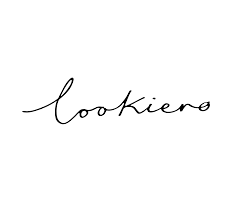    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

- **Pyspark**

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import lit, trim, split, regexp_replace, when

- **Strings**

In [3]:
from collections import Counter
import re

- **Visualización**

In [4]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

* **Grafos**

In [5]:
import networkx as nx

- **Otros**

In [6]:
import itertools

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [7]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [8]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        try: 
            path = os.getcwd()
            csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []
            for i in csv_files:
                temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
                dataframes_list.append(temp_df)
  
        except: pass
            
        return dataframes_list
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [9]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [10]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [11]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [12]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

* Función que crea el grafo filtrando por temporada

In [13]:
def sacar_productos(e, variable, tallas = False):
    if tallas:
        list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
        list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
    else:
        list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
        list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

    return list(itertools.product(list_1, list_2))

def create_graph(o):
    
    ##############
    ##### DF #####  
    ##############

    ### Filtrar por temporada ###
    df2 = df.filter(df.season == o)
    
    ### Conseguir variantes de productos únicos#####
    vu_id_product = get_value(df2, 'id_product')
    
    ### Crear df para filtrar ###
    df_para_filtrar = pd.DataFrame(vu_id_product).reset_index()
    df_para_filtrar['family_product'] = pd.Series([e[0] for e in df_para_filtrar[0].str.split('_')])
    df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)
    df_para_filtrar.columns = ['index', 'id_product', 'family_product', 'level']
    
    def sacar_productos(e, variable, tallas = False):
        if tallas:
            list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
            list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
        else:
            list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
            list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

        return list(itertools.product(list_1, list_2))

    #############
    ### NODOS ###
    #############

    G = nx.Graph()
    
    for i in range(len(vu_id_product)):
            G.add_node(i,
                      color = vu_id_product[i].split('_')[1],
                      size  = vu_id_product[i].split('_')[2],
                      level = df_para_filtrar['level'][i])
            
    ###############        
    ### ARISTAS ###
    ###############

    ### Aristas - Tallas ###
    df_para_filtrar['talla'] = df_para_filtrar['id_product'].apply(lambda x:x.split('_')[-1])
    orden_tallas = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL','X4XL']
                
    combinaciones_tallas_letra = []
    for i in range(1, len(orden_tallas)): combinaciones_tallas_letra += [(orden_tallas[i - 1], orden_tallas[i])]
    combinaciones_talla = list(map(sacar_productos, combinaciones_tallas_letra, ['talla'], [True]))[0]
    
    ### Aristas - Level ###
    levels = get_value(df2.filter(df2.id_product.isin(vu_id_product)), 'level')
    levels.sort()
    tods = list(itertools.combinations(levels, 2))
    tods.sort()
    tods += [('3.2', '3.2')]
    tods.remove(('1.1', '1.2'))

    combinaciones_level = list(map(sacar_productos, tods, ['level']))[0]
    
    ### Se añaden todas las aristas ###
    G.add_edges_from(list(set(combinaciones_level + combinaciones_talla)))

    ### Se empieza poniendo un peso de 0 a todas las aristas ###
    for x in G.edges(): G[x[0]][x[1]]['weight'] = 1
    return G



---

In [14]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

### Adecuar el *dataframe* size

In [15]:
size = cd.subir_una_tabla(dir_in, 'size')
size.to_csv(dir_out + 'size2.csv', sep = ';')
dfs[-1] = spark.read.csv(path = dir_out + 'size2.csv', header = True, inferSchema = True, sep = ';')

### Unión de *dataframes*

<center> 
<img  src="../imagenes/diagrama.PNG" height = 800> 

#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

* Renombrar con sufijos para facilitar el *join*

In [16]:
dfs[-1] = rename_columns(dfs[-1], '_size')
dfs[1] = rename_columns(dfs[1], '_color')

* Se junta los 2 dataframes en uno solo.

In [17]:
df_total = dfs[10].join(dfs[-1].select('id_size','lookiero_size'), dfs[10].size_id == dfs[-1].id_size, "inner").drop('id_size', 'size_id')
df_total = df_total.join(dfs[1].select('id_color', 'name_color'), df_total.color_id == dfs[1].id_color).drop('id_color', 'color_id', 'legacy_id', 'barcode')
df_total = df_total.withColumn("publishable", when(df_total.publishable == "f",False).when(df_total.publishable == "t",True))
df_total = df_total.withColumnRenamed("lookiero_size","size_lookiero") \
    .withColumnRenamed("name_color","color")

* Se modifica la variable size_lookiero para que tenga formato legible

In [18]:
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ':').getItem(1))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '""', ''))
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ',').getItem(0))
df_total = df_total.withColumn('size_lookiero', trim(f.col("size_lookiero")))

#### 2) df_total += product

product_variant + product = 41291 (63'3%) with no product_family or brand NAN

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

* Crear las parejas

In [19]:
product = dfs[7].drop('legacy_id', 'channels')

unique_values_family =  [x['family_id'] for x in product.select('family_id').distinct().collect()]
parejas = dict(map(get_family_name, unique_values_family))
product = product.withColumn("product_family", product["family_id"])

* Mapear las parejas creadas

In [20]:
for k, v in enumerate(unique_values_family): 
    product = product.withColumn('product_family', regexp_replace('product_family', v, str(parejas[v])))

* Renombra la columna a la hora de unir

In [21]:
product = product.drop('family_id', 'title', '"""group"""')
product = rename_columns(product, '_product')

df_total = df_total.join(product, df_total.product_id == product.id_product).drop('product_id')
df_total = df_total.withColumnRenamed("product_family_product","family_product")

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [22]:
brand = dfs[0].drop('number')
brand = brand.withColumnRenamed("id","id").withColumnRenamed("name","brand").withColumnRenamed("origin","brand_origin")
brand = rename_columns(brand, '_brand')
df_total = df_total.join(brand, df_total.brand_id_product == brand.id_brand).drop('brand_id_product','brand_id', 'id_brand')
df_total = df_total.withColumnRenamed("brand_brand", "name_brand").withColumnRenamed("brand_origin_brand", "origin_brand")

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [23]:
feature = dfs[3]
feature = feature.withColumn("multiple", when(feature.multiple == "f",False).when(feature.multiple == "t",True))
column_names = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

for k, v in enumerate(column_names):  feature = feature.withColumnRenamed(feature.schema.names[k], v)
feature_value = dfs[5]
feature = rename_columns(feature, '_values')
values = feature_value.join(feature, feature_value.feature_id == feature.id_values).drop('feature_id','id_values', 'feature_type_values', 'unit_values')

### **Hay que corregirlo pero no sé cómo**	

feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [24]:
for k, v in enumerate(['feature_family', 'feature_value_id']):  dfs[6] = dfs[6].withColumnRenamed(dfs[6].schema.names[k], v)
values = values.join(dfs[6], values.id == dfs[6].feature_value_id).drop('feature_value_id')

#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [25]:
values = values.withColumnRenamed('id', 'id_values')
dfs[8] = dfs[8].withColumnRenamed('id', 'id_product_feature')
product_values = values.join(dfs[8], values.id_values == dfs[8].feature_value_id).drop('feature_value_id')

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [26]:
df = df_total.join(product_values, df_total.id_product == product_values.product_id).drop('product_id')

* Adecuar variables para la comprensión

In [27]:
df = df.drop('id_values', 'multiple_values') # id_product_feature
df = df.withColumnRenamed('feature_multiple_values', 'multiple_values').withColumnRenamed('feature_name_values','name_feature')
df = df.withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color') , lit('_'), f.col('size_lookiero'), lit('_'), f.col('season')))
df = df.withColumn('id_product_feature', f.concat(f.col('name_feature'), lit('_'), f.col('value')))

- id = Un único producto (se repite pork tiene diferentes features)  
- id_product = El producto en general (niki manga larga)  
- id_values = id de una característica (**borrado**)     
- id_product_feature = id de la característica de un producto en general (id_product)(**borrado**)

In [28]:
print((df.count(), len(df.columns)))
df.show()

(14285646, 15)
+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+
|                  id|season|stock|publishable|size_lookiero|    color|          id_product|family_product|name_brand| origin_brand|value|name_feature|multiple_values|      feature_family|id_product_feature|
+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+
|498662e5-11e8-483...|     8|    0|       true|            M|     ecru|   cardigan_ecru_M_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|          false|c6b81db8-29ed-43d...|    hip_contour_55|
|dcda2fe4-58e3-4b2...|     8|    0|       true|            S|     ecru|   cardigan_ecru_S_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|  

### Relaciones
---

* Crear variables para verificar reglas

In [29]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

df = df.withColumn('level', df['family_product'])
df = df.na.replace(niveles, subset = ['level'])

**COMBINACIONES NO POSIBLES:**
- 1.2 + 3.2 + 3.2 (*falta parte de arriba*)
- 2.1 + 2.1 (*demasiados nikis*)
- 2.2 + 2.2 (*demasiados jerses*)
- 3.1 + 3.1 (*demasiadas txammaras*)

### Guardamos datos
---

In [53]:
df_total_pd = df_total.toPandas()
df_total_pd.to_csv(dir_out + 'df_total.csv', index=False)

---